# Homework 4 - Fairness
For HW 4, you will apply technical approaches to evaluating fairness on a real-world dataset.

***MAKE YOUR OWN COPY OF THIS FILE BEFORE YOU START.***

# Sections:
- **Real Application - Crime**: Visualize and filter real-world dataset on crime statistics.
- **Decile Score**: Visulize decile scores by different demographics.
- **Risk Category**: Visulize risk category distributions by different demographics.
- **Defendant Statistics**: Verify the balance of our dataset.
- **FPR & FNR Analysis**: Calculate false positive and false negative rates.
- **Bias Analysis**: Calculate odds ratios between different demographics.

## To-Do List:

Complete each task and submit your Jupyter notebook on Blackboard.

Look out for sections marked "# IMPLEMENT" and "# QUESTION". Both Undergraduate and Masters students will complete the same questions
- 4 Implement Blocks + 3 Question Block = 7 Points Total

Partial credit can be earned.

In [1]:
# Import Useful Libraries
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## [1] Real Application - Recidivism

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). This dataset contains the criminal history, jail and prison time, demographics and COMPAS decile scores for defendants from Broward County from 2013 and 2014. It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). The pattern of mistakes, as measured by precision/sensitivity is notable (https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing).

In [2]:
# Download ProPublica's Formatted Data
!wget -Nq https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv
!wget -Nq https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
!wget -Nq https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv
!wget -Nq https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-violent-parsed.csv

In [3]:
# Load Data into Pandas Dataframe
df_raw_data = pd.read_csv("compas-scores-two-years.csv")

# Preview Dataset
print(df_raw_data.shape)
df_raw_data.head(5)

(7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:

'''

Feature Description

"age": Age of the defendant. It is numeric.
"age_cat": Category of Age. It can be < 25, 25-45, >45.
"sex": Sex of the defendant. It is either 'Male' or 'Female'
"race": Race of the defendant. It can be 'African-American', 'Caucasian', 'Hispanic', 'Asian', or 'Other'.
"c_charge_degree": Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).
"priors_count": Count of prior crimes committed by the defendant. It is numeric.
"days_b_screening_arrest": Days between the arrest and COMPAS screening.
"decile_score": The COMPAS score predicted by the system. It is between 0-10. 10 - high risk.
"score_text": Category of COMPAS decile score. It can be Low (1-4), Medium (5-7), and High (8-10).
"is_recid": A variable to indicate if recidivism was done by the defendant. It can be 0, 1, -1.
"two_year_recid": A variable to indicate if recidivism was done by the defendant within two years.
"c_jail_in": Time when the defendant was jailed.
"c_jail_out": Time when the defendant was released from the jail.

'''

'\n\nFeature Description\n\n"age": Age of the defendant. It is numeric.\n"age_cat": Category of Age. It can be < 25, 25-45, >45.\n"sex": Sex of the defendant. It is either \'Male\' or \'Female\'\n"race": Race of the defendant. It can be \'African-American\', \'Caucasian\', \'Hispanic\', \'Asian\', or \'Other\'.\n"c_charge_degree": Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).\n"priors_count": Count of prior crimes committed by the defendant. It is numeric.\n"days_b_screening_arrest": Days between the arrest and COMPAS screening.\n"decile_score": The COMPAS score predicted by the system. It is between 0-10. 10 - high risk.\n"score_text": Category of COMPAS decile score. It can be Low (1-4), Medium (5-7), and High (8-10).\n"is_recid": A variable to indicate if recidivism was done by the defendant. It can be 0, 1, -1.\n"two_year_recid": A variable to indicate if recidivism was done by the defendant within two years.\n"c_jail_in": Time when th

In [5]:
# Keep Subset of Columns from Original Dataset
cols_to_keep = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in',
               'c_jail_out']

# Create Copy of Dataset with Subset of Columns
df1 = df_raw_data[cols_to_keep].copy()
print(df1.shape)

(7214, 13)


In [6]:
# Data Cleaning
# Condition 1 - Remove Petty Traffic Offenses that Don't Result in Jail Time
cond_1 = (df_raw_data.c_charge_degree != 'O')

# Condition 2 - Remove Rows without COMPAS Score
cond_2 = (df_raw_data.score_text != 'N/A') & (df_raw_data.is_recid != -1)

# Condition 3 - Remove Cases with Charge Dates > 30 days
cond_3 = (df_raw_data.days_b_screening_arrest <= 30) & (df_raw_data.days_b_screening_arrest >= -30)

# Create Copy of Dataset with Conditions Met
df2 = df1[(cond_1 & cond_2 & cond_3)].copy()
print(df2.shape)
df2.head()

(6172, 13)


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


## [2] Decile Score

A judge is often presented with two sets of scores from the COMPAS system -- one that classifies people into high, medium and low risk category, and a corresponding decile score (1-10). Let us take a look at sex and race for decile score and risk category.

These COMPAS scores are captured in columns `decile_score` and `score_text `. Let's look into `decile_score` in this section.

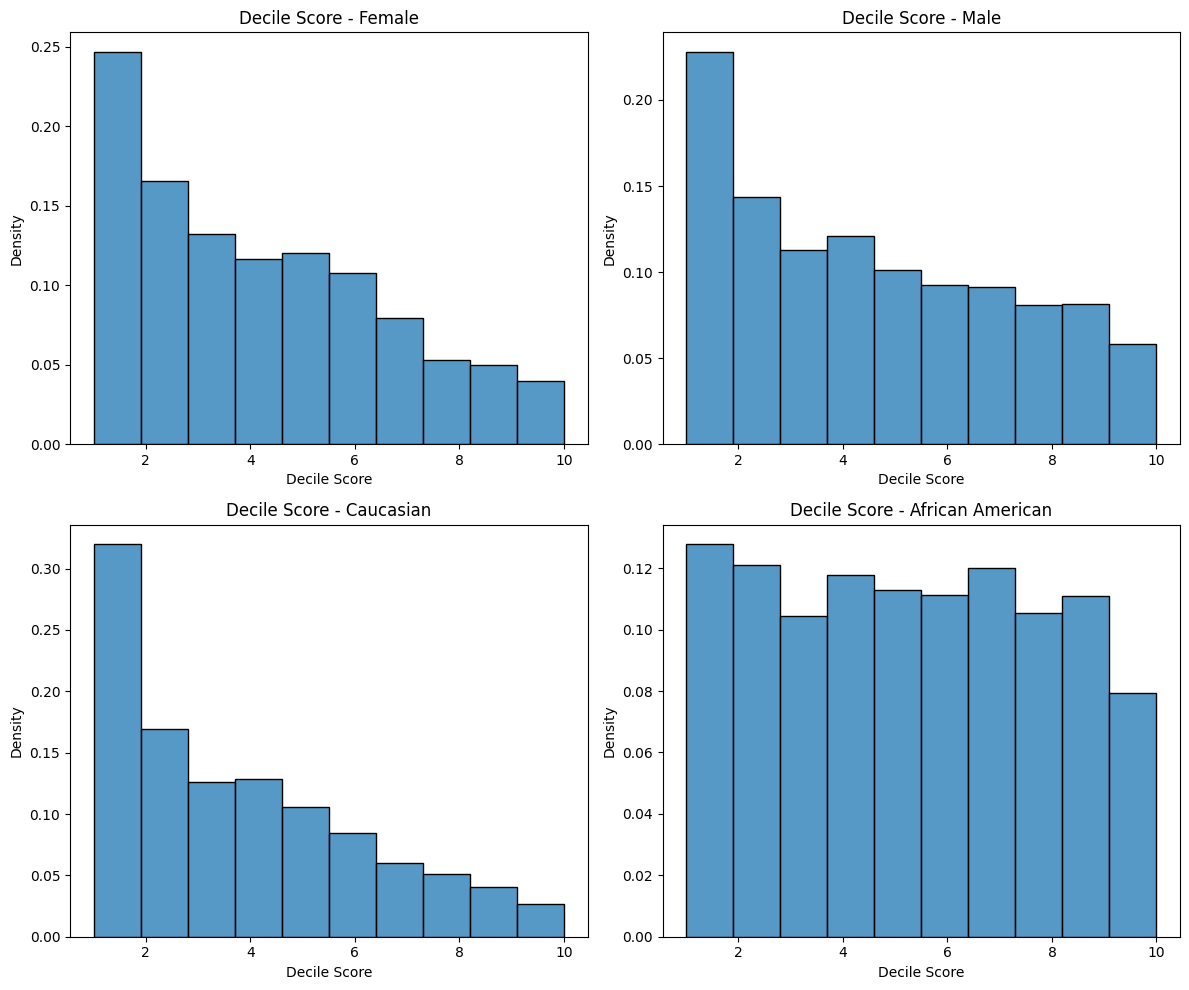

In [7]:
'''

    Plot a histogram for decile score - female

    Plot a histogram for decile score - male

    Plot a histogram for decile score - Caucasian

    Plot a histogram for decile score - African American

    For each chart, the x-axis should represent the decile score and the y-axis represents the density (% of population with each decile score).

'''

# -------------------------------------------------------------------------
# IMPLEMENT - 0.5 Point
# -------------------------------------------------------------------------
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Filter data for female
sns.histplot(df2[df2['sex'] == 'Female']['decile_score'], bins=10,  stat='density', ax=axs[0, 0])
axs[0, 0].set_title('Decile Score - Female')

# Filter data for male
sns.histplot(df2[df2['sex'] == 'Male']['decile_score'], bins=10,  stat='density', ax=axs[0, 1])
axs[0, 1].set_title('Decile Score - Male')

# Filter data for Caucasian
sns.histplot(df2[df2['race'] == 'Caucasian']['decile_score'], bins=10, stat='density', ax=axs[1, 0])
axs[1, 0].set_title('Decile Score - Caucasian')

# Filter data for African American
sns.histplot(df2[df2['race'] == 'African-American']['decile_score'], bins=10, stat='density', ax=axs[1, 1])
axs[1, 1].set_title('Decile Score - African American')

for ax in axs.flat:
    ax.set_xlabel('Decile Score')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [8]:
'''

    Q: Is there a visual difference (female vs male, Caucasian vs African American)?
       If so, comment on this difference.

'''

# -------------------------------------------------------------------------
# QUESTION - 0.5 Point
# -------------------------------------------------------------------------

# Your answer
'''Female vs Male:'''
'''Yes, there is a visual difference in female vs male. The histogram for males indicate high density in middle to high decile scores, suggesting that males have a higher risk of recidivism other than female.'''
'''The histogram for females indicate sparse density in higher decile scores and thus indicate that females are scored as lower risk as compared to males.'''

'''Caucasian vs African American:'''
'''Yes, there is visual difference in these too. The African American histogram is evenly distributed, suggesting that African Americans are assigned a wider range of risk scores, and receive higher decile scores as compared to Caucassian. '''
'''The Caucassian histogram is left skewed indicating that Caucassian are assigned only lower decile scores.'''

'The Caucassian histogram is left skewed indicating that Caucassian are assigned only lower decile scores.'

## [3] Risk Category

A judge is often presented with two sets of scores from the COMPAS system -- one that classifies people into high, medium and low risk category, and a corresponding decile score (1-10). Let us take a look at sex and race for decile score and risk category.

These COMPAS scores are captured in columns `decile_score` and `score_text `. Let's look into `score_text` in this section.

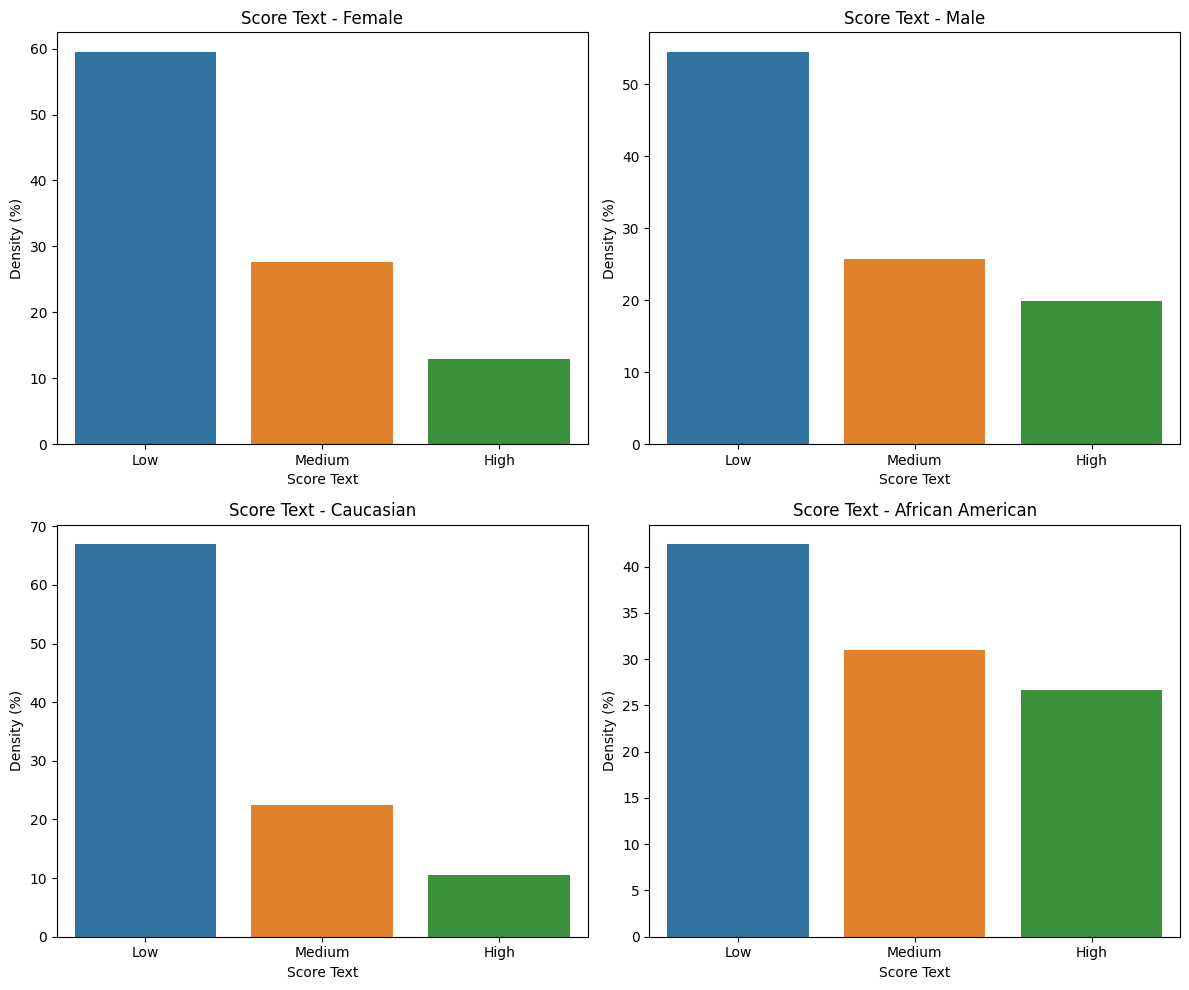

In [9]:
'''

    Plot a bar graph for score_text (risk category) - female

    Plot a bar graph for score_text (risk category) - male

    Plot a bar graph for score_text (risk category) - Caucasian

    Plot a bar graph for score_text (risk category) - African American

    For each chart, the x-axis should represent the score_text (risk category) and the y-axis represents the density (% of population with each score_text).


'''

# -------------------------------------------------------------------------
# IMPLEMENT - 0.5 Point
# -------------------------------------------------------------------------


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded your data into a DataFrame named 'df2'

# Create sub-dataframes for each category
female_data = df2[df2['sex'] == 'Female']
male_data = df2[df2['sex'] == 'Male']
caucasian_data = df2[df2['race'] == 'Caucasian']
african_american_data = df2[df2['race'] == 'African-American']

# Calculate the percentage of each score_text category for each subgroup
def calculate_percentage(data):
    return data['score_text'].value_counts(normalize=True) * 100

# Calculate percentages for each subgroup
female_scores_percentage = calculate_percentage(female_data)
male_scores_percentage = calculate_percentage(male_data)
caucasian_scores_percentage = calculate_percentage(caucasian_data)
african_american_scores_percentage = calculate_percentage(african_american_data)

# Create subplots for the bar graphs
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot bar graph for score_text (risk category) - female
sns.barplot(x=female_scores_percentage.index, y=female_scores_percentage.values, ax=axs[0, 0])
axs[0, 0].set_title('Score Text - Female')
axs[0, 0].set_xlabel('Score Text')
axs[0, 0].set_ylabel('Density (%)')

# Plot bar graph for score_text (risk category) - male
sns.barplot(x=male_scores_percentage.index, y=male_scores_percentage.values, ax=axs[0, 1])
axs[0, 1].set_title('Score Text - Male')
axs[0, 1].set_xlabel('Score Text')
axs[0, 1].set_ylabel('Density (%)')

# Plot bar graph for score_text (risk category) - Caucasian
sns.barplot(x=caucasian_scores_percentage.index, y=caucasian_scores_percentage.values, ax=axs[1, 0])
axs[1, 0].set_title('Score Text - Caucasian')
axs[1, 0].set_xlabel('Score Text')
axs[1, 0].set_ylabel('Density (%)')

# Plot bar graph for score_text (risk category) - African American
sns.barplot(x=african_american_scores_percentage.index, y=african_american_scores_percentage.values, ax=axs[1, 1])
axs[1, 1].set_title('Score Text - African American')
axs[1, 1].set_xlabel('Score Text')
axs[1, 1].set_ylabel('Density (%)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()




In [ ]:
'''

 Q: Is there a visual difference (female vs male, Caucasian vs African American)?
    If so, comment on this difference.

'''

# -------------------------------------------------------------------------
# QUESTION - 0.5 Point
# -------------------------------------------------------------------------

# Your answer.
# Female vs Male
# Yes, there is significant visual difference between female and male.
# The high score text for male is more than the high score text for female suggesting that more men are involved in heinous crimes as compared to women.
#
# Caucasian vs African American
# Yes, there is significant visual difference between Cuacasian and African American.
# The medium and high score texts for African American are greater than Caucasian suggesting that African American are involved in more dangerous crimes as compared to Caucasian.

'\n\n Q: Is there a visual difference (female vs male, Caucasian vs African American)?\n    If so, comment on this difference.\n\n'

## [4] Defendant Statistics

In [ ]:
'''

    Print the breakdown/percentage of defendants by sex

    Print the breakdown/percentage of defendants by race

'''

# -------------------------------------------------------------------------
# IMPLEMENT - 0.5 Point
# -------------------------------------------------------------------------
sex_breakdown = df2['sex'].value_counts(normalize=True) * 100
print("Percentage of Defendants by Sex:")
print(sex_breakdown)

race_breakdown = df2['race'].value_counts(normalize=True) * 100
print("\nPercentage of Defendants by Race:")
print(race_breakdown)

Percentage of Defendants by Sex:
Male      80.962411
Female    19.037589
Name: sex, dtype: float64

Percentage of Defendants by Race:
African-American    51.441996
Caucasian           34.073234
Hispanic             8.246922
Other                5.557356
Asian                0.502268
Native American      0.178224
Name: race, dtype: float64


In [ ]:
'''

 Q: Is there a data imbalance (female vs male, Caucasian vs African American)?
    If so, comment on this difference.

'''

# -------------------------------------------------------------------------
# QUESTION - 0.5 Point
# -------------------------------------------------------------------------

# Your answer.
# Yes there is data imbalance among the classes
# The percentage of male is almost 4 times the percentage of female.
# the percentage of African American is half of all the defendants by race, making it as the majority class.
# The percentage of Caucasian is 1.5 times less than African American
# All the other classes are in minority(Hispanic, Other, Asian, Native American)

'\n\n Q: Is there a data imbalance (female vs male, Caucasian vs African American)?\n    If so, comment on this difference.\n\n'

## [5] FPR & FNR Analysis

In this section, we will reproduce some of the analysis form the ProPublica study based on Cox regression.

In [ ]:
# Load Cox Data
raw_cox_df = pd.read_csv("cox-parsed.csv")

# Calculate Time in System per Person
raw_cox_df['lifetime'] = raw_cox_df['end'] - raw_cox_df['start']

# Aggregate Lifetimes by ID and Get Entry per Person
grouped_df = raw_cox_df.groupby('id').first()
grouped_df['lifetime'] = raw_cox_df.groupby('id')['lifetime'].sum()

# Make Copy of Data
raw_cox_df = grouped_df.copy()

# Label Recidivist According to Dataset
raw_cox_df['recidivist'] = (raw_cox_df['is_recid'] == 1) \
                & (raw_cox_df['lifetime'] <= 730)

# Use Valid Rows for Experiment (according to ProPublica)
is_valid = (raw_cox_df['recidivist'] == True) \
            | (raw_cox_df['lifetime'] > 730)

# Only Get Valid Rows
cox_df = raw_cox_df[is_valid].copy()

# Label People that Did Recidivate as 1 (ground truth) & Mark Prediction as 1 for People given Med or High risk by COMPAS
cox_df['did_crime_after'] = (cox_df['recidivist'] == True)
cox_df['high_predicted_risk'] = cox_df['score_text'] != 'Low'

In [ ]:
'''

    Given true positive, false positive, false negative, and true negative.

    Conduct data analysis - compute population breakdown, false positive rate, false
    rate, specificity, and sensitivity.

    Show the analysis table.

    Example:

                        Low	  High
    Not Recidivated   	2681	1291	0.55
    Recidivated		      1216	2037	0.45

    Total: 7225.00
    False positive rate: 0.33
    False negative rate: 0.37
    Specificity: 0.67
    Sensitivity: 0.63

'''

# -------------------------------------------------------------------------
# IMPLEMENT - 1 Point
# -------------------------------------------------------------------------

def print_tables(tn, fp, fn, tp):
    # Computes Rates from Here: https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    # Based on true negative, false positive, false negative, and true positives
    total_population = tn + fp + fn + tp

    # Population breakdown table
    print("Population Breakdown:")
    print(f"{'':<15} {'Low':<10} {'High':<10}")
    print(f"Not Recidivated {tn:<10} {fp:<10} {((tn + fp) / total_population):.2f}")
    print(f"Recidivated     {fn:<10} {tp:<10} {((fn + tp) / total_population):.2f}")
    print(f"Total: {total_population}\n")

    # Calculating rates
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Displaying rates
    print(f"False positive rate: {false_positive_rate:.2f}")
    print(f"False negative rate: {false_negative_rate:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")



In [ ]:
'''

                        Low	  High
    Not Recidivated   	2681	1291	0.55
    Recidivated		      1216	2037	0.45

    Total: 7225.00
    False positive rate: 0.33
    False negative rate: 0.37
    Specificity: 0.67
    Sensitivity: 0.63

    Make sure your results matched with the one shown above.

'''

true_positives = ((cox_df['did_crime_after'] == True) & (cox_df['high_predicted_risk'] == True)).sum()
false_positives = ((cox_df['did_crime_after'] == False) & (cox_df['high_predicted_risk'] == True)).sum()
true_negatives = ((cox_df['did_crime_after'] == False) & (cox_df['high_predicted_risk'] == False)).sum()
false_negatives = ((cox_df['did_crime_after'] == True) & (cox_df['high_predicted_risk'] == False)).sum()

print_tables(true_negatives, false_positives, false_negatives, true_positives)

Population Breakdown:
                Low        High      
Not Recidivated 2681       1291       0.55
Recidivated     1216       2037       0.45
Total: 7225

False positive rate: 0.33
False negative rate: 0.37
Specificity: 0.67
Sensitivity: 0.63


In [ ]:
'''

    Run the analysis below broken by gender and answer the following question:
    Q: Is there a difference by gender? If so, comment on this difference.

'''

# -------------------------------------------------------------------------
# QUESTION - 1 Point
# -------------------------------------------------------------------------

print("Female")
selected_subset = cox_df['sex'] == 'Female'
subset_df = cox_df[selected_subset]
true_positives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == True)).sum()
false_positives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == True)).sum()
true_negatives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == False)).sum()
false_negatives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == False)).sum()
print_tables(true_negatives, false_positives, false_negatives, true_positives)

print("")
print("Male")
selected_subset = cox_df['sex'] == 'Male'
subset_df = cox_df[selected_subset]
true_positives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == True)).sum()
false_positives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == True)).sum()
true_negatives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == False)).sum()
false_negatives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == False)).sum()
print_tables(true_negatives, false_positives, false_negatives, true_positives)


# Your answer.
# False Positive Rate: Both genders show a relatively similar false positive rate (around 0.32-0.33), implying that the proportion of individuals labeled as 'High' risk who did not recidivate is comparable for both genders.

# False Negative Rate: Both genders have similar false negative rates (around 0.37-0.39), indicating a similar proportion of individuals labeled as 'Low' risk who did recidivate.

# Specificity: The specificity for both genders is approximately the same (around 0.67-0.68), meaning the ability to correctly identify non-recidivists (true negatives) is similar for both genders.

# Sensitivity: The sensitivity, which measures the proportion of actual positives correctly identified (true positives), is also close (around 0.61-0.63) for both genders.

Female
Population Breakdown:
                Low        High      
Not Recidivated 609        291        0.64
Recidivated     195        303        0.36
Total: 1398

False positive rate: 0.32
False negative rate: 0.39
Specificity: 0.68
Sensitivity: 0.61

Male
Population Breakdown:
                Low        High      
Not Recidivated 2072       1000       0.53
Recidivated     1021       1734       0.47
Total: 5827

False positive rate: 0.33
False negative rate: 0.37
Specificity: 0.67
Sensitivity: 0.63


In [ ]:
'''

    Run the analysis below broken by race and answer the following question:
    Q: Is there a difference by race? If so, comment on this difference.

'''

# -------------------------------------------------------------------------
# QUESTION - 1 Point
# -------------------------------------------------------------------------

print("Caucasian")
selected_subset = cox_df['race'] == 'Caucasian'
subset_df = cox_df[selected_subset]
true_positives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == True)).sum()
false_positives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == True)).sum()
true_negatives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == False)).sum()
false_negatives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == False)).sum()
print_tables(true_negatives, false_positives, false_negatives, true_positives)

print("")
print("African American")
selected_subset = cox_df['race'] == 'African-American'
subset_df = cox_df[selected_subset]
true_positives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == True)).sum()
false_positives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == True)).sum()
true_negatives = ((subset_df['did_crime_after'] == False) & (subset_df['high_predicted_risk'] == False)).sum()
false_negatives = ((subset_df['did_crime_after'] == True) & (subset_df['high_predicted_risk'] == False)).sum()
print_tables(true_negatives, false_positives, false_negatives, true_positives)


# Your answer.
# False Positive Rate:
# Caucasian: The false positive rate for Caucasians is notably lower (0.24) compared to African Americans (0.45), indicating a lower proportion of individuals incorrectly classified as high risk who did not recidivate.
# African American: This group shows a higher false positive rate (0.45), meaning a larger proportion of individuals labeled as 'High' risk did not recidivate.

# False Negative Rate:
# Caucasian: The false negative rate for Caucasians is higher (0.48) compared to African Americans (0.28). This suggests a larger proportion of individuals labeled as 'Low' risk who did recidivate for Caucasians.
# African American: This group exhibits a lower false negative rate (0.28), implying that a smaller proportion of individuals labeled as 'Low' risk actually recidivated.

# Specificity and Sensitivity:
# Caucasian: Higher specificity (0.76) but lower sensitivity (0.52) compared to African Americans.
# African American: Lower specificity (0.55) but higher sensitivity (0.72) compared to Caucasians.

Caucasian
Population Breakdown:
                Low        High      
Not Recidivated 1139       355        0.61
Recidivated     461        506        0.39
Total: 2461

False positive rate: 0.24
False negative rate: 0.48
Specificity: 0.76
Sensitivity: 0.52

African American
Population Breakdown:
                Low        High      
Not Recidivated 990        807        0.49
Recidivated     532        1370       0.51
Total: 3699

False positive rate: 0.45
False negative rate: 0.28
Specificity: 0.55
Sensitivity: 0.72


## [6] Bias Analysis

The aim is to create a logistic regression model that predicts whether a defendant is going to be assigned low risk vs high risk of recdivism by COMPAS, given attributes of the defendant. After creating the model, we will look at the effects of the race, gender, and age variables while reducing the effect of confounding variables.  It means that when looking at the effect of one variable, the effects of all other variable predictors are taken into account by making the other variables take on a fixed value.

In [ ]:
# Data Cleaning
df3 = df2.copy(deep=True)

# One-hot Encode 'c_charge_degree'
dummies_c_charge_degree = pd.get_dummies(df3['c_charge_degree'])
df3 = pd.concat([df3, dummies_c_charge_degree], axis=1)
df3 = df3.drop(['c_charge_degree'], axis=1)

# One-hot Encode 'age_cat' (use 25-45 as default)
dummies_age_cat = pd.get_dummies(df3['age_cat'])
df3 = pd.concat([df3, dummies_age_cat], axis=1)
df3 = df3.drop(['age_cat', '25 - 45'], axis=1)      # Dropping 25 - 45 as when < 25 = 0 and > 45 = 0, it automatically means 25 - 45 = 1

# One-hot Encode 'race' (use Caucasian as default)
dummies_race = pd.get_dummies(df3['race'])
df3 = pd.concat([df3, dummies_race], axis=1)
df3 = df3.drop(['race', 'Caucasian'], axis=1)

# One-hot Encode 'sex' (use Male as default)
dummies_sex = pd.get_dummies(df3['sex'])
df3 = pd.concat([df3, dummies_sex], axis=1)
df3 = df3.drop(['sex', 'Male'], axis=1)

# Convert 'score_text' to take binary values where Low = LowScore and Medium/High = HighScore
df3['score_text']= np.where(df3['score_text'] == "Low", "LowScore", df3['score_text'])
df3['score_text']= np.where(df3['score_text'] != "LowScore", "HighScore", df3['score_text'])
df3['score_text'] = df3['score_text'].astype('category')

# Rename Columns for Final Dataframe
renamed_cols = {'African-American':'African_American', 'Greater than 45':'Greater_than_45',
                'Less than 25':'Less_than_25', 'Native American':'Native_American', 'F': 'Felony',
               'M': 'Misdemeanor'}

df3 = df3.rename(columns=renamed_cols)

In [ ]:
# Run Logistic Regression Model via statsmodel.
attributes = 'priors_count + two_year_recid + Misdemeanor + Greater_than_45 + Less_than_25 + \
African_American + Asian + Hispanic + Native_American + Other + Female'
target = 'score_text'
formula = target + ' ~ ' + attributes

model = sm.formula.glm(formula=formula, family=sm.families.Binomial(), data = df3).fit()
print(formula)
print(model.summary())

score_text ~ priors_count + two_year_recid + Misdemeanor + Greater_than_45 + Less_than_25 + African_American + Asian + Hispanic + Native_American + Other + Female
                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['score_text[HighScore]', 'score_text[LowScore]']   No. Observations:                 6172
Model:                                                           GLM   Df Residuals:                     6160
Model Family:                                               Binomial   Df Model:                           11
Link Function:                                                 Logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -3084.2
Date:                                               Mon, 20 Nov 2023   Deviance:                       6168.4
Time:                                                       22:36:5

### Odds Ratio

From the above table, we see a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.

To compare the odds of two variables happening, we get the odds ratio of those two variables.

Mathematically, this would be:

$$\ln{(\frac{y}{1-y})} = w_0 + w_1 x_1$$

where: <br />
$x_1$ = Female (say), then -> when $x_1 = 1$, it's Female, when $x_1 = 0$, it's Male <br />

Therefore,

$w_0 + w_1$ = **log odds** of high recividism for Female defendants, <br />
$w_0$ = **log odds** of high recividism for Male defendants


To get the odds (and not the log odds), we transform the above equation to get:

$e^{w_0 + w_1}$ = **odds** of high recividism for Female defendants, <br />
$e^{w_0}$ = **odds** of high recividism for Male defendants, <br />

To get the odd ratio, we divide the two odds to compare them.

In [ ]:
# Gather Coefficients of Learned Model from statsmodel
coefficients = model.params

In [ ]:
'''

    Q: Is there a difference for sex and race? If so, comment/interprete on this difference.

'''

# -------------------------------------------------------------------------
# QUESTION - 1 Point
# -------------------------------------------------------------------------

female_odds = np.exp(coefficients["Intercept"]+coefficients["Female"])
male_odds = np.exp(coefficients["Intercept"])
sex_odds_ratio = female_odds / male_odds
print("Sex (Female to Male) - Odds Ratio:", sex_odds_ratio)

aa_odds = np.exp(coefficients["Intercept"]+coefficients["African_American"])
ca_odds = np.exp(coefficients["Intercept"])
race_odds_ratio = aa_odds / ca_odds
print("Race (African American vs Caucasian) - Odds Ratio:", race_odds_ratio)


# Your answer.
# For both sex and race, the odds ratios suggest that there are differences in the way the model predicts recidivism. These differences may indicate potential biases in the model's predictions.
# The model appears to be more likely to predict recidivism for females and African Americans compared to males and Caucasians, respectively.
# This could lead to disparities in the criminal justice system if these predictions are used to make decisions about individuals.


Sex (Female to Male) - Odds Ratio: 1.2476561040261969
Race (African American vs Caucasian) - Odds Ratio: 1.6115669697085973
